In [20]:
# Real time air quality from the data portal
# compare march 2020 and march 2024 AQ

In [44]:
import pandas as pd
import numpy as np 
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

import seaborn as sns
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
import plotly.express as px

In [232]:
# Some default plotting params
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['font.size'] = 18  # Set default font size for text
mpl.rcParams['axes.labelsize'] = 12  # Font size for x and y labels
mpl.rcParams['axes.titlesize'] = 18  # Font size for title
mpl.rcParams['xtick.labelsize'] = 8  # Font size for x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12  # Font size for y-axis tick labels
mpl.rcParams['legend.fontsize'] = 8  # Font size for legend

In [16]:
!ls
!ls /AQ_dat_nycgov/ 

Borough_average_annual_daily_traffic.jpeg
Borough_average_truck_traffic.jpeg
Data_traffic
Exploratory_air_March.ipynb
Exploratory_analysis_air.ipynb
Exploratory_analysis_traffic.ipynb
FromDataportalAug16
Images_NYC_gov
NYC EH Data Portal - Fine particles (PM 2.5) (filtered) (1).csv
Untitled.ipynb
Untitled1.ipynb
Untitled2.ipynb
Untitled3.ipynb
hourlyMonitoringJuly2024.csv
location.json
location_July2024.csv
monthly_observation_counts_by_boro.jpeg
ls: /AQ_dat_nycgov/: No such file or directory


In [18]:
raw_2020 = pd.read_csv("FromDataportalAug16//hourlyMonitoringMarch2020.csv")
raw_2024 = pd.read_csv("FromDataportalAug16//hourlyMonitoringMarch2024.csv")

In [92]:
raw_2020['ObservationTimeUTC'] = pd.to_datetime(raw_2020['ObservationTimeUTC'])
raw_2024['ObservationTimeUTC'] = pd.to_datetime(raw_2024['ObservationTimeUTC'])

In [24]:
raw_2020.head()

,ID,SiteID,ObservationTimeUTC,Value
0,187700,36081NY09285,2020-04-01,5.08
1,187701,36061NY09734,2020-04-01,6.27
2,187702,36061NY09929,2020-04-01,5.15
3,187703,36061NY08454,2020-04-01,5.10
4,187704,36061NY10130,2020-04-01,7.41


In [26]:
# PREP
loc_json = json.load(open('location.json', 'r'))
loc_json_gpd = gpd.GeoDataFrame(
    loc_json,
    geometry=[Point(xy) for xy in zip([loc['Longitude'] for loc in loc_json], [loc['Latitude'] for loc in loc_json])]
)
# centroid = loc_json_gpd.geometry.unary_union.centroid
# center = {"lat": centroid.y, "lon": centroid.x}
loc_json_gpd.head()

,SiteID,Latitude,Longitude,SiteName,Address,geometry
0,36061NY08454,40.716510,-73.997004,Manhattan Bridge,Canal St SS1E of Elizabeth St,POINT (-73.99700 40.71651)
1,36005NY11790,40.819092,-73.885659,Hunts Point,Southeast Corner of Seneca Ave and Longfellow Ave,POINT (-73.88566 40.81909)
2,36081NY08198,40.707113,-73.873400,Glendale,Cooper Rapid Rehousing Center - 78-16 Cooper Ave,POINT (-73.87340 40.70711)
3,36081NY09285,40.737107,-73.821556,Queens College,Queens College Reference Site,POINT (-73.82156 40.73711)
4,36061NY09734,40.750690,-73.987830,Broadway/35th St,Broadway ES1N of 35th St,POINT (-73.98783 40.75069)


In [28]:
loc_json_gpd['SiteName'].value_counts()

SiteName
Manhattan Bridge       1
BQE                    1
Port Richmond          1
Midtown-DOT            1
Hamilton Bridge        1
Williamsburg Bridge    1
Queensboro Bridge      1
Williamsburg           1
Van Wyck               1
Hunts Point            1
Cross Bronx Expy       1
Mott Haven             1
FDR                    1
Broadway/35th St       1
Queens College         1
Glendale               1
SI Expwy               1
Name: count, dtype: int64

In [ ]:
# Subset Manhattan Bridge, WilliamsburgBridge, Broadway/35th St, Queensboro Bridge, Manhattan Bridge, FDR 
locations=['Manhattan Bridge', 'FDR', 'Broadway/35th St']
site_ids = loc_json_gpd[loc_json_gpd['SiteName'].isin(locations)]['SiteID'].tolist()

In [190]:
def get_week_means(df):
    summary = df.groupby('day_of_week')['Value'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index(name='mean_aq')
    return summary

def get_hourly_means(df):
    summary = df.groupby('hour_of_day')['Value'].mean().reset_index(name='mean_aq')
    return summary

In [106]:
NY_2020 = raw_2020[raw_2020['SiteID'].isin(site_ids)].copy()
NY_2024 = raw_2024[raw_2024['SiteID'].isin(site_ids)].copy()

In [ ]:
def add_date_dat(df):
    """
    add columns for date data
    """
    df['hour_of_day'] = df['ObservationTimeUTC'].dt.hour
    df['day'] = df['ObservationTimeUTC'].dt.day
    df['year'] = df['ObservationTimeUTC'].dt.year
    return df

NY_2024 = add_date_dat(NY_2024)
NY_2020 = add_date_dat(NY_2020)

In [188]:
wk_2020=get_week_means(NY_2020)
wk_2020

wk_2024=get_week_means(NY_2024)
wk_2024

,day_of_week,mean_aq
0,Monday,5.928333
1,Tuesday,6.264644
2,Wednesday,13.586174
3,Thursday,12.086199
4,Friday,8.717167
5,Saturday,7.077056
6,Sunday,6.628389


In [196]:
# get hourly means for two years and combine
hr_2020=get_hourly_means(NY_2020)
hr_2024=get_hourly_means(NY_2024)
hr_2020['year']=2020
hr_2024['year']=2024
hr_avgs =pd.concat([hr_2020, hr_2024])

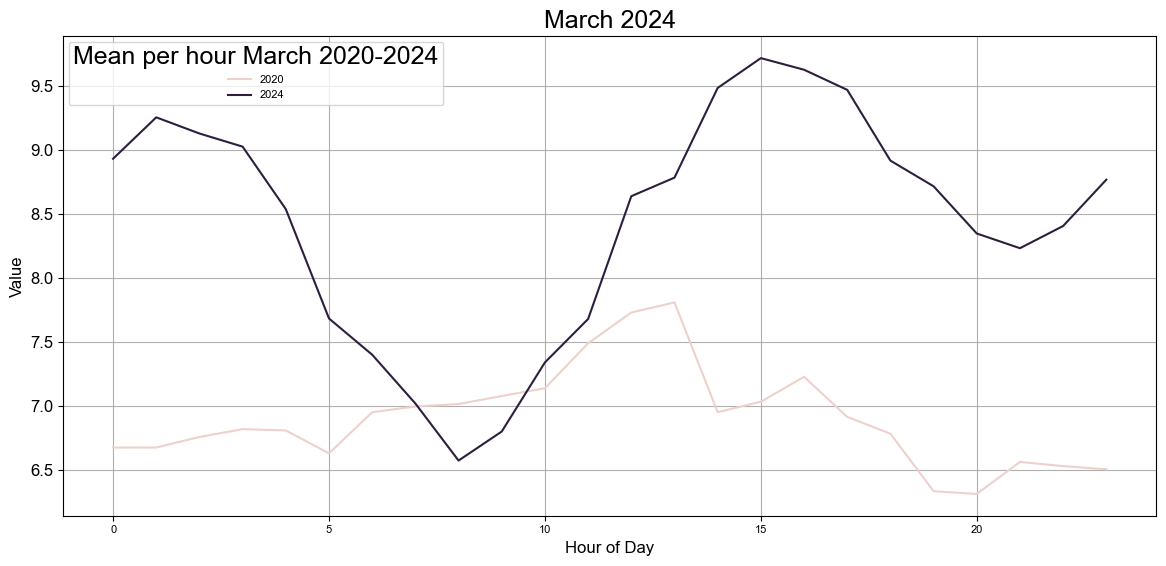

In [202]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=hr_avgs, x='hour_of_day', y='mean_aq', hue='year')
plt.title('March 2024')
plt.xlabel('Hour of Day')
plt.ylabel('Value')
plt.grid(True)
plt.legend(title='Mean per hour March 2020-2024')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=NY_2024, x='hour_of_day', y='Value', hue='day')
plt.title('March 2024')
plt.xlabel('Hour of Day')
plt.ylabel('Value')
plt.grid(True)
plt.legend(title='Day')
plt.tight_layout()
plt.show()

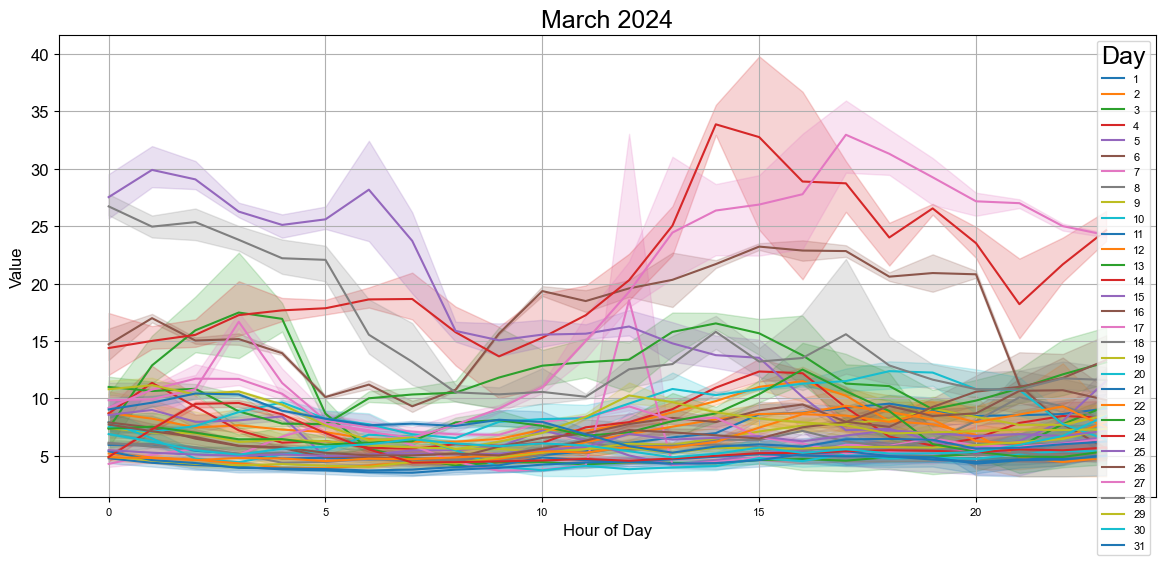

In [122]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=NY_2024, x='hour_of_day', y='Value', hue='day')
plt.title('March 2024')
plt.xlabel('Hour of Day')
plt.ylabel('Value')
plt.grid(True)
plt.legend(title='Day')
plt.tight_layout()
plt.show()

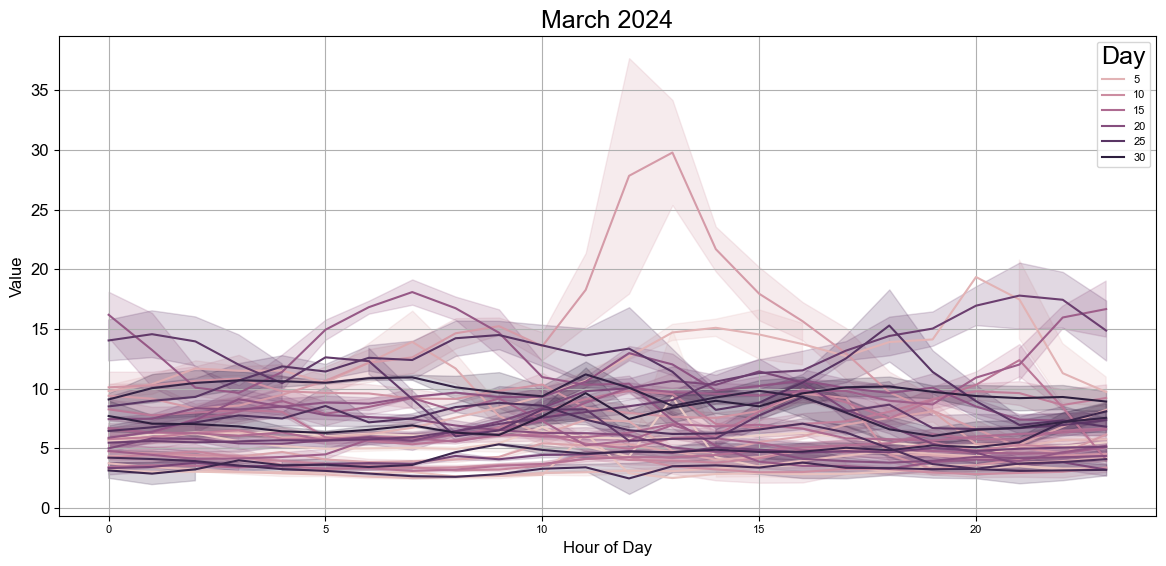

In [128]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=NY_2020, x='hour_of_day', y='Value', hue='day')
plt.title('March 2024')
plt.xlabel('Hour of Day')
plt.ylabel('Value')
plt.grid(True)
plt.legend(title='Day')
plt.tight_layout()
plt.show()

In [208]:
NY_fulldat = pd.concat([NY_2020, NY_2024])
NY_fulldat.head()

,ID,SiteID,ObservationTimeUTC,Value,hour_of_day,day,day_of_week,year
1,187701,36061NY09734,2020-04-01 00:00:00,6.27,0,1,Wednesday,2020
3,187703,36061NY08454,2020-04-01 00:00:00,5.10,0,1,Wednesday,2020
6,187706,36061NY09734,2020-04-01 01:00:00,6.90,1,1,Wednesday,2020
8,187708,36061NY08454,2020-04-01 01:00:00,5.42,1,1,Wednesday,2020
11,187711,36061NY09734,2020-04-01 02:00:00,7.04,2,1,Wednesday,2020


In [256]:
!pwd

/Users/zoelye/Documents/Brainstation/capstone


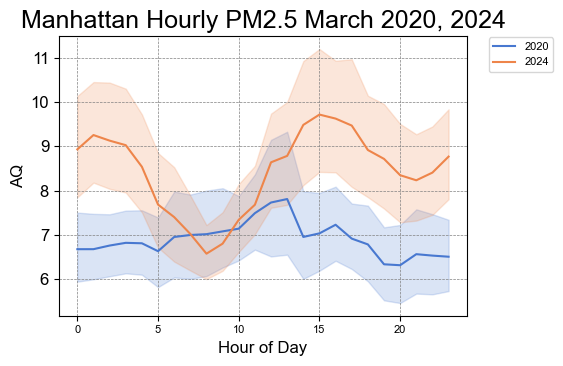

In [258]:
plt.figure(figsize=(6, 4))
plt.grid(True)
sns.lineplot(data=NY_fulldat, x='hour_of_day', y='Value', hue='year', palette='muted')
plt.title('Manhattan Hourly PM2.5 March 2020, 2024')
# palette = sns.color_palette("tab20")
plt.xlabel('Hour of Day')
plt.ylabel('AQ')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1)
plt.tight_layout()
plt.savefig('Manhattan Hourly PM2.5 March 2020, 2024.jpeg', format='jpeg', dpi=300)
plt.show()


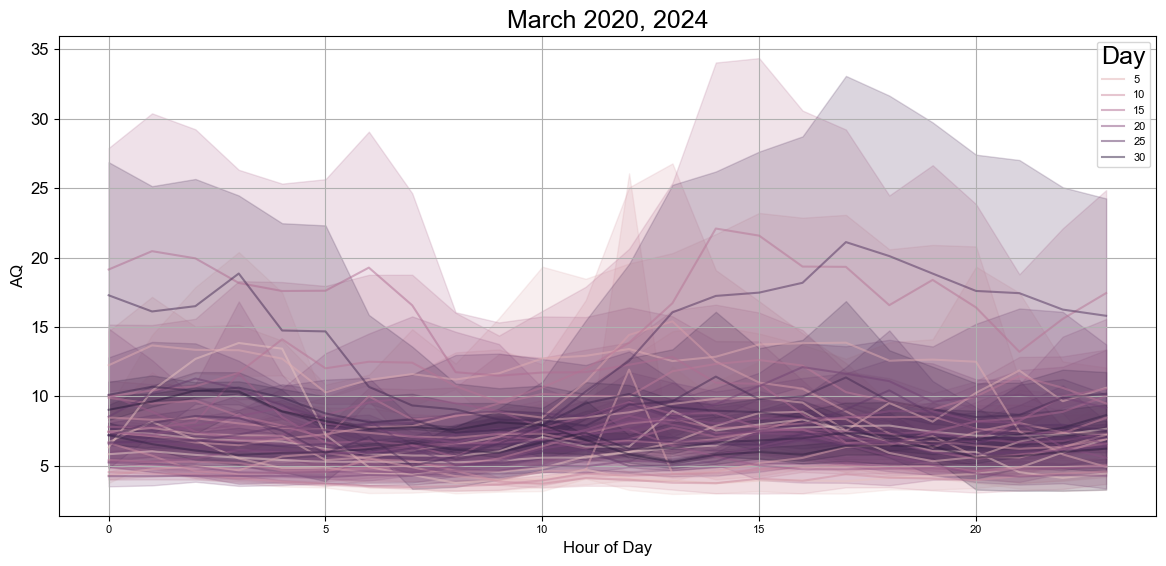

In [218]:
mean_values = df.groupby('hour_of_day')['Value'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data= NY_fulldat, x='hour_of_day', y='Value', hue='day', alpha=0.5)
plt.title('March 2020, 2024')
plt.xlabel('Hour of Day')
plt.ylabel('AQ')
plt.grid(True)
plt.legend(title='Day')
plt.tight_layout()
plt.show()

In [ ]:
raw_2020